## Imports

In [1]:
# numerics
import pandas as pd
# tables
import numpy as np

In [2]:
# plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as po

In [3]:
# graphs
import networkx as nx

## Function Definition

#### Convenience

In [4]:
def autocomplete_product(stump):
    """ Autocomplete (Case Insensitive) Product Name and provide ID """
    # for each product
    for x in raw.product_name.unique():
        # if it contains provided stump
        if x.lower().__contains__(stump.lower()):
            # print name and id
            print(f"{x} - {name_to_id[x]}")

#### Graphs

In [5]:
def create_graph(df, name, plot=False, offline=True, notebook=False):
    """
    Create Graph of products. Node size ~ totals sales. Edge strength ~ shared sales adjusted for total sales.
    
    :df -> Dataframe to generate edges from
    :name -> file suffix for html page
    :offline -> create html page with plot and display as new tab
    :notebook -> display in notebook
    """
    # create edgelist
    G = nx.from_pandas_edgelist(df, source="product_x", target="product_y", edge_attr=True)
    # position nodes using Fruchterman-Reingold force-directed algorithm
    pos_ = nx.spring_layout(G)
    
    # generate plotly trace for every edge
    edge_trace = []
    for edge in G.edges():

        if G.edges()[edge]['weight'] > 0:
            prod_1 = edge[0]
            prod_2 = edge[1]

            x0, y0 = pos_[prod_1]
            x1, y1 = pos_[prod_2]
            # generate hovertext (only displays on starting point. Bug in Plotly https://community.plotly.com/t/plotly-hover-event-not-getting-triggered-for-al-data-points/387)
            text   = str(id_to_name[prod_2]) + '--' + str(id_to_name[prod_1]) + ': ' + str(G.edges()[edge]['weight'])
            # calculate adjusted width
            width = G.edges()[edge]['weight']/(0.2*prod_count[prod_1]+0.2*prod_count[prod_2])
            # generate trace
            trace = go.Scatter(x = [x0, x1, None], y = [y0, y1, None],
                               line      = dict(width=width, color='green'),
                               hoverinfo = 'text',
                               text      = ([text]),
                               mode      = 'lines')
            # append to edge_trace list
            edge_trace.append(trace)
            
    # create empty node trace
    node_trace = go.Scatter(x = [], y = [],
                            text      = [],
                            textposition = "top center",
                            textfont_size = 10,
                            mode      = 'markers+text',
                            hoverinfo = 'none',
                            marker    = dict(color=[], size=[], line=None))
    # add every node to node_trace 
    for node in G.nodes():
        x, y = pos_[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['marker']['color'] += tuple(['cornflowerblue'])
        node_trace['marker']['size'] += tuple([np.log(prod_count[node])])
        node_trace['text'] += tuple([id_to_name[node]])
    # create layout
    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    # create figure
    fig = go.Figure(layout = layout)
    
    # add edge traces
    for trace in edge_trace:
        fig.add_trace(trace)
    
    # add node traces
    fig.add_trace(node_trace)
    
    # cleanup layout
    fig.update_layout(showlegend = False)
    fig.update_xaxes(showticklabels = False)
    fig.update_yaxes(showticklabels = False)
    # display in specified way(s)
    if notebook:
        fig.show()
    if offline:
        po.plot(fig, filename=f'networks/network_{name}.html')

In [6]:
def cl_department(department):
    """
    Create Cooccurrency List for Department
    
    :department -> department for which to filter for
    """
    # filter and copy
    df = raw[raw.department == department][["order_id", "product_id"]].copy()
    # rename columns
    df.rename(columns={"order_id":"order", "product_id":"product"}, inplace=True)
    # create cooccurrency list
    # steps:
    # merge to self and drop rows with reflexive relationship
    # group by both products and count occurences
    # rename columns
    # filter duplicate rows
    # sort and reset index
    df_coocc = df.merge(df, on=['order']).query('product_x != product_y')\
        .groupby(['product_x','product_y'], as_index=False).count()\
        .rename(columns={'order':'weight'})\
        .query('product_x < product_y')\
        .sort_values(by="weight", ignore_index=True)
    return df_coocc

In [7]:
def graph_product(product_id, top_n=25, filter_dict=None, offline=True, notebook=False):
    """
    Draw Cooccurrency Graph for specified Product
    
    :product_id -> center of graph
    :filter_dict -> limit by condition passsed as dict. To filter to county Alpine,
    pass filter_dict = {"county": "Alpine"}
    :top_n -> number of relationships to include (by absolute number of cooccurrencies)
    :offline -> create html page with plot and display as new tab
    :notebook -> display in notebook
    """
    # create copy
    df = raw.copy()
    # filter rows that dont satisfy conditions if filters are passed
    if filter_dict:
        for key in filter_dict.keys():
            df = df[df[key] == filter_dict[key]]
    df = df[["order_id", "product_id"]]
    # rename columns
    df.rename(columns={"order_id":"order", "product_id":"product"}, inplace=True)
    # create cooccurrency list
    # steps:
    # merge to self and filter to relevant rows
    # drop reflexive relationships
    # group by both products and count occurences
    # rename columns
    # filter duplicate rows
    # sort and reset index
    df_coocc = df.merge(df, on=['order']).query(f'product_x == {product_id} | product_y == {product_id}')\
            .query('product_x != product_y')\
            .groupby(['product_x','product_y'], as_index=False).count()\
            .rename(columns={'order':'weight'})\
            .query('product_x < product_y')\
            .sort_values(by="weight", ignore_index=True)
    # draw graph
    create_graph(df_coocc.tail(top_n), product_id, offline=offline, notebook=notebook)

#### Layouts

In [8]:
def check_pair(a,b):
    """ Lookup Cross Selling Rate for Targets a and b """
    # if either is 0, return 0
    if a == 0 or b == 0:
        return 0
    # lookup cross selling rate. If a,b dont cross sell, triggers Float conversion error and returns 0
    try:
        return float(df_layout.query(f"x == {a} & y == {b}")["cross_sell_rate"])
    except TypeError:
        return 0
    
def get_nbs(pos):
    """ Get Neighbors for any Given Position """
    # unpack pos and init nbs (neighbors)
    x,y = pos
    nbs = []
    # check x and y in bounds
    if 0<=x<rows and 0<=y<cols:
        # add top neighbor if exists
        if x > 0:
            nbs.append(grid[x-1,y])
        # add bottom neighbor if exists
        if x < rows-1:
            nbs.append(grid[x+1,y])
        # add left neighbor if exists
        if y > 0:
            nbs.append(grid[x,y-1])
        # add right neighbor if exists
        if y < cols-1:
            nbs.append(grid[x,y+1])
    return nbs

def score_tile(target, pos):
    """ Compute Score for Target at Pos """
    # sum up cross selling rates between target and all neighbors
    return sum([check_pair(target, other) for other in get_nbs(pos)])

def next_free():
    """ Return Next Free Position in Grid """
    # find all positions with 0 (=no target assigned)
    pos = np.where(grid==0)
    # return first x and y coordinate
    return pos[0][0], pos[1][0]

def place_target(pos, unplaced):
    """ Place Best Available Target at pos """
    # unpack pos
    x,y = pos
    # track score for each unplaced target in dictionary
    scores = {target: score_tile(target, pos) for target in unplaced}
    # find best target
    best_target = max(scores, key=scores.get)
    # place target in grid
    grid[x,y] = best_target
    # return list of unplaced without target that was just placed
    return unplaced[unplaced != best_target]

In [9]:
def get_layout(target="aisle_id", filter_dict=None, columns=3, random=False):
    """ 
    Construct 2D Layout for target based on Cross Selling rate 
    
    :filter_dict -> limit by condition passsed as dict. To filter to department canned goods,
    pass filter_dict = {"department_id": "canned goods"}
    :random -> don't use greedy heuristic and instead place randomly
    """

    # filter data to target and order_id
    global df_layout
    if filter_dict:
        for key in filter_dict.keys():
            df_layout = raw[raw[key] == filter_dict[key]][["order_id", target]].copy()
    else:
        df_layout = raw[["order_id", target]].copy()
    # create cooccurence list for all target pairs
    # steps
    # merge to self and filter to relevant rows
    # group by both targets and count occurences
    # rename columns
    df_layout = df_layout.merge(df_layout, on=['order_id']).query(f'{target}_x != {target}_y')\
                .groupby([f'{target}_x',f'{target}_y'], as_index=False).count()\
                .rename(columns={'order_id':'cross_sells', f'{target}_x':'x', f'{target}_y':'y'})
    # compute cross selling rate
    if target == "aisle_id":
        df_layout["cross_sell_rate"] = df_layout["cross_sells"] / df_layout["x"].apply(lambda x: aisle_count[x])
    elif target == "department_id":
        df_layout["cross_sell_rate"] = df_layout["cross_sells"] / df_layout["x"].apply(lambda x: dep_count[x])
    else:
        raise NotImplementedError(f"Sorry {target} is not supported yet")
    # sort
    df_layout.sort_values(by="cross_sell_rate", ascending=False, inplace=True, ignore_index=True)
    
    # define grid size
    global cols
    global rows
    # excuse the globals, this should have been a class 
    cols = columns
    # rows are given by number targets / columns rounded up
    rows = int(np.ceil(df_layout["x"].nunique()/cols))

    # initialize grid for both target and cross selling rate to neighbors
    global grid
    global score_grid
    # excuse the globals part 2: this really should have been a class
    grid = np.zeros((rows, cols))
    score_grid = np.zeros((rows, cols))
    
    # get list of all targets
    unplaced = df_layout.x.unique()
    
    # while some are unplaced
    while len(unplaced) > 0:
        # place best available target at next free position
        unplaced = place_target(next_free(), unplaced)

    # for every position
    for x in range(rows):
        for y in range(cols):
            # compute score and track in seperate matrix
            score_grid[x,y] = score_tile(grid[x,y], (x,y))
    return grid, score_grid

In [10]:
def draw_layout(grid, score_grid, target="aisle_id", filename="Unnamed"):
    """ 
    draw given layout colored by scores with aisle name as label 
    
    :grid -> aisle positions as matrix
    :score_grid -> corresponding cross selling rates
    :filename -> filename
    """
    # get shape
    rows, cols = grid.shape
    # init figure
    scale = 15
    fig, ax = plt.subplots(figsize=(scale,scale))
    # show cross selling rates 
    ax.matshow(score_grid, cmap=plt.cm.Blues)

    # for every position
    for x in range(rows):
        for y in range(cols):
            # add label name \n cross selling rate
            if target == "aisle_id":
                name = aisle_id_to_name[grid[x,y]] + f"\n {round(score_grid[x,y],3)}" if grid[x,y] in aisle_id_to_name.keys() else None
            elif target == "department_id":
                name = dep_id_to_name[grid[x,y]] + f"\n {round(score_grid[x,y],3)}" if grid[x,y] in dep_id_to_name.keys() else None
            else:
                raise NotImplementedError(f"Sorry {target} is not supported yet")
            ax.text(y,x, name, va='center', ha='center')
    fig.savefig(f"layouts/{filename}_{cols}.png")

## Preprocessing

In [11]:
# read raw data
raw = pd.read_parquet("shoppingcarts.parquet")

In [12]:
# create lookup tables for id to name and vice versa 
# for product
id_to_name = dict(zip(raw.product_id.unique(), raw.product_name.unique()))
name_to_id = dict(zip(raw.product_name.unique(), raw.product_id.unique()))
# for aisle
aisle_id_to_name = dict(zip(raw.aisle_id.unique(), raw.aisle.unique()))
aisle_name_to_id = dict(zip(raw.aisle.unique(), raw.aisle_id.unique()))
# for department
dep_id_to_name = dict(zip(raw.department_id.unique(), raw.department.unique()))
dep_name_to_id = dict(zip(raw.department.unique(), raw.department_id.unique()))

In [13]:
# count number of orders per product
prod_count = raw.groupby("product_id")["order_id"].count()
# count number of orders per aisle
aisle_count = raw.groupby("aisle_id")["order_id"].count()
# count number of orders per department
dep_count = raw.groupby("department_id")["order_id"].count()

## Analysis

### Out of Context Wordcloud

In [12]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

corpus = word_tokenize(' '.join(raw.head(10000)['product_name']))
wc = WordCloud(background_color='white', random_state=1, max_words=3000, width=1200, height=1200)
wc.generate(' '.join(corpus))

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.show()

### Sales By Department

In [13]:
px.bar(raw.groupby("department")["order_id"].count().sort_values())

### Graphs

#### Top 5000 Products per Department (no need to run again)

In [ ]:
# for every department
for department in raw.department.unique():
    # create cooccurrency list
    cl_department(department).to_csv(f"cls\cl_{department}.csv")

In [ ]:
# for every department
for department in raw.department.unique():
    # read cooccurrency list
    df_coocc = pd.read_csv(f"cls\cl_{department}.csv", index_col="Unnamed: 0").tail(5000)
    # draw graph
    create_graph(df_coocc, name=department)

#### Live Demo

In [14]:
# Use this to find Product-Ids
# shows all products containing stub. Case insensitive
autocomplete_product("Organic Extra Virgin Olive Oil")

Organic Extra Virgin Olive Oil - 21195
Vitamin D Organic Extra Virgin Olive Oil 1000 Mg Softgels - 40246
Organic Extra Virgin Olive Oil from Tunisia - 41130
Organic Extra Virgin Olive Oil Popped Corn - 15506
100% Italian Organic Extra Virgin Olive Oil - 8129
Organic Extra Virgin Olive Oil from Greece - 49471
California Organic Extra Virgin Olive Oil - 35869


In [15]:
# create product graph
# offline -> create html page with plot and display as new tab
# notebook -> display in notebook
graph_product(product_id=21195, top_n=25, filter_dict={"county": "Alpine"}, offline=True, notebook=False)

### Search for Layout

In [16]:
grid, score_grid = get_layout(target="aisle_id", filter_dict={"department": "snacks"}, columns=4, random=False)

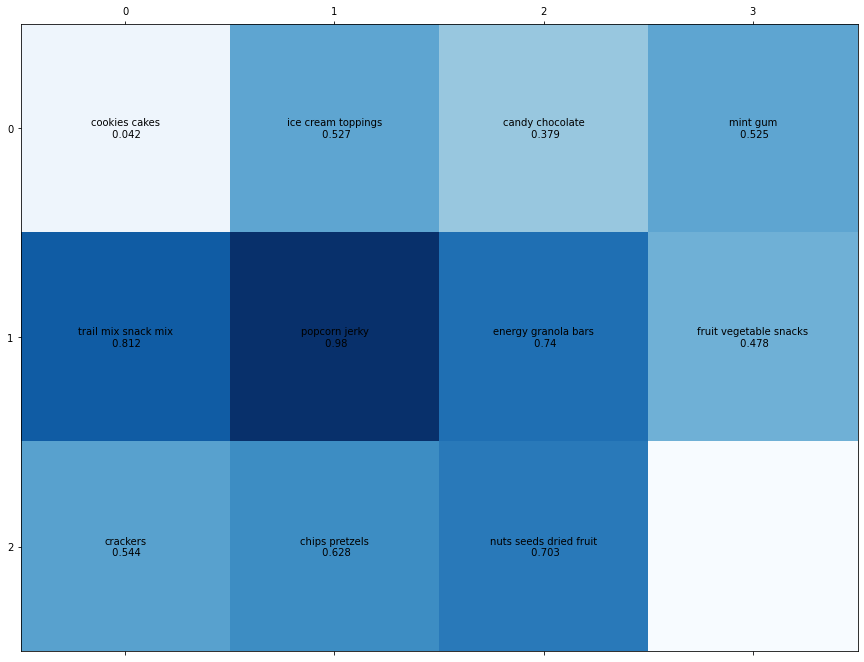

In [17]:
draw_layout(grid, score_grid, filename="Departments")

In [18]:
grid, score_grid = get_layout(target="department_id", filter_dict=None, columns=5, random=False)

In [19]:
draw_layout(grid, score_grid, filename="Departments")